In [21]:
import pandas as pd
import numpy as np
from sklearn import utils
from spellchecker import SpellChecker
import nltk
import string
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from matplotlib import pyplot as plt

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adriallopgirones/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/adriallopgirones/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/adriallopgirones/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adriallopgirones/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Importing Dataset 

In [22]:
df_train = pd.read_csv("archive/train.txt", sep=";", names=["tweets","emotions"])
df_test = pd.read_csv("archive/test.txt", sep=";", names=["tweets","emotions"])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweets    16000 non-null  object
 1   emotions  16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB


joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: emotions, dtype: int64
[5362 4666 2159 1937 1304  572]


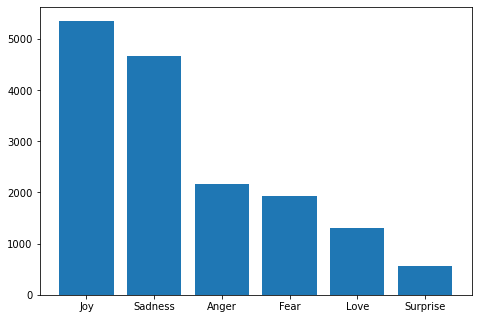

In [23]:
print(df_train["emotions"].value_counts())
print(df_train["emotions"].value_counts().values)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
count = df_train["emotions"].value_counts().values
emotions = ['Joy', 'Sadness', 'Anger', 'Fear', 'Love', 'Surprise']
ax.bar(emotions,count)
plt.show()


# Preprocessing

In [24]:
# Removing emotions love and surprise to balance the dataset
df_train = df_train[df_train.emotions != "love"]
df_train = df_train[df_train.emotions != "surprise"]

df_test = df_test[df_test.emotions != "love"]
df_test = df_test[df_test.emotions != "surprise"]

In [25]:
# Lemmatization and removing stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) 

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    
    sentence = sentence.lower()
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        # Removing stop words
        if word not in stop_words:
            if tag is None:
                #if there is no available tag, append the token as is
                lemmatized_sentence.append(word)
            else:        
                #else use the tag to lemmatize the token
                lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
        else:
            continue
            
    return " ".join(lemmatized_sentence)

# Applying the functions
df_train["tweets"] = df_train["tweets"].apply(lemmatize_sentence)
df_test["tweets"] = df_test["tweets"].apply(lemmatize_sentence)


# Embedding

In [26]:
# TF-IDF Vectorization

vectorizer = TfidfVectorizer(max_features=2000)
vectors = vectorizer.fit_transform(df_train["tweets"])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df_train_embedded_tfidf = pd.DataFrame(denselist, columns=feature_names)

vectors = vectorizer.transform(df_test["tweets"])
dense = vectors.todense()
denselist = dense.tolist()
df_test_embedded_tfidf = pd.DataFrame(denselist, columns=feature_names)


In [27]:
# Doc2vec
train_tagged = []
for tweet, emotion in zip(df_train["tweets"], df_train["emotions"]):
    train_tagged.append(TaggedDocument(tweet.split(), emotion))

test_tagged = []
for tweet, emotion in zip(df_test["tweets"], df_test["emotions"]):
    test_tagged.append(TaggedDocument(tweet.split(), emotion))
                                                 
model_dbow = Doc2Vec(dm=1, vector_size=1000, negative=5, hs=0, min_count=2, sample = 0, workers=4, 
                     alpha=0.025, min_alpha=0.001)

model_dbow.build_vocab([x for x in train_tagged])

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in train_tagged]), total_examples=len(train_tagged), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [28]:
targets, df_train_embedded_doc2vec = zip(*[(doc.tags, model_dbow.infer_vector(doc.words, steps=20)) for doc in train_tagged])
targets2, df_test_embedded_doc2vec = zip(*[(doc.tags, model_dbow.infer_vector(doc.words, steps=20)) for doc in test_tagged])



In [74]:
# # Testing
# a = vectorizer.transform([""])
# prova = a.todense().tolist()
# provant = pd.DataFrame(prova, columns=feature_names)
# grid.predict(provant)

# Modeling

In [30]:
def fit(model, parameters, X_train, y_train, X_test):
    steps = [model]
    pipeline = Pipeline(steps)
    grid = GridSearchCV(pipeline, param_grid=parameters)
    grid.fit(X_train, y_train)
    
    print(model)
    print(grid.best_params_)
    print(predict_score(X_test, df_test['emotions'], grid))
    
    return grid

def predict_score(Y, Y_true, grid):
    preds = grid.predict(Y)
    reports.append(classification_report(preds, Y_true, ["joy", "sadness", "anger", "fear"], output_dict=True))
    print(classification_report(preds, Y_true, ["joy", "sadness", "anger", "fear"]))
    print(confusion_matrix(Y_true, preds, labels=["joy", "sadness", "anger","fear"]))
    
    

In [32]:
models = [('lr', LogisticRegression(random_state=0,max_iter=10000)), 
          ('dt', DecisionTreeClassifier()),
          ('mnb', MultinomialNB()),
          ('nb',BernoulliNB())]

parameters = [{'lr__C': [0.1,1.0,10.0]}, 
              {'dt__criterion':['gini', 'entropy']},
              {'mnb__alpha': np.linspace(0.0, 1.0, 5)},
              {'nb__alpha': np.linspace(0.0, 1.0, 5)}]

reports = []

for model, parameters_dic in zip(models, parameters):
    print("td-idf")
    grid = fit(model, parameters_dic, df_train_embedded_tfidf, df_train["emotions"], df_test_embedded_tfidf)
    print("Doc2Vec")
    # mnb and nb cannot deal with negative val ues
    if model[0] != "mnb" and model[0] != "nb":
        grid = fit(model, parameters_dic, df_train_embedded_doc2vec, df_train["emotions"], df_test_embedded_doc2vec)


td-idf
('lr', LogisticRegression(max_iter=10000, random_state=0))
{'lr__C': 10.0}
              precision    recall  f1-score   support

         joy       0.97      0.93      0.95       722
     sadness       0.90      0.91      0.90       574
       anger       0.82      0.87      0.84       260
        fear       0.85      0.87      0.86       219

    accuracy                           0.91      1775
   macro avg       0.88      0.90      0.89      1775
weighted avg       0.91      0.91      0.91      1775

[[673  10   5   7]
 [ 29 521  19  12]
 [ 12  28 226   9]
 [  8  15  10 191]]
None
Doc2Vec


/Users/adriallopgirones/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=['joy', 'sadness', 'anger', 'fear'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


('lr', LogisticRegression(max_iter=10000, random_state=0))
{'lr__C': 10.0}
              precision    recall  f1-score   support

         joy       0.94      0.90      0.92       731
     sadness       0.85      0.87      0.86       571
       anger       0.77      0.81      0.79       262
        fear       0.79      0.84      0.81       211

    accuracy                           0.87      1775
   macro avg       0.84      0.85      0.85      1775
weighted avg       0.87      0.87      0.87      1775

[[656  21   8  10]
 [ 46 495  28  12]
 [ 21  29 213  12]
 [  8  26  13 177]]
None
td-idf


/Users/adriallopgirones/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=['joy', 'sadness', 'anger', 'fear'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


('dt', DecisionTreeClassifier())
{'dt__criterion': 'gini'}
              precision    recall  f1-score   support

         joy       0.92      0.92      0.92       696
     sadness       0.86      0.89      0.88       563
       anger       0.84      0.81      0.82       285
        fear       0.86      0.83      0.84       231

    accuracy                           0.88      1775
   macro avg       0.87      0.86      0.86      1775
weighted avg       0.88      0.88      0.88      1775

[[638  30  18   9]
 [ 33 501  27  20]
 [ 16  19 230  10]
 [  9  13  10 192]]
None
Doc2Vec


/Users/adriallopgirones/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=['joy', 'sadness', 'anger', 'fear'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


('dt', DecisionTreeClassifier())
{'dt__criterion': 'entropy'}
              precision    recall  f1-score   support

         joy       0.90      0.87      0.88       718
     sadness       0.81      0.81      0.81       582
       anger       0.72      0.76      0.74       260
        fear       0.76      0.79      0.77       215

    accuracy                           0.82      1775
   macro avg       0.79      0.81      0.80      1775
weighted avg       0.82      0.82      0.82      1775

[[623  45  14  13]
 [ 62 469  35  15]
 [ 23  38 197  17]
 [ 10  30  14 170]]
None
td-idf


/Users/adriallopgirones/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=['joy', 'sadness', 'anger', 'fear'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/adriallopgirones/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
/Users/adriallopgirones/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
/Users/adriallopgirones/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.war

('mnb', MultinomialNB())
{'mnb__alpha': 0.25}
              precision    recall  f1-score   support

         joy       0.97      0.86      0.91       789
     sadness       0.90      0.84      0.87       625
       anger       0.66      0.90      0.76       202
        fear       0.63      0.89      0.74       159

    accuracy                           0.86      1775
   macro avg       0.79      0.87      0.82      1775
weighted avg       0.88      0.86      0.86      1775

[[675  13   4   3]
 [ 48 522   7   4]
 [ 37  47 181  10]
 [ 29  43  10 142]]
None
Doc2Vec
td-idf


/Users/adriallopgirones/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=['joy', 'sadness', 'anger', 'fear'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/adriallopgirones/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
/Users/adriallopgirones/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
/Users/adriallopgirones/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.war

('nb', BernoulliNB())
{'nb__alpha': 0.75}
              precision    recall  f1-score   support

         joy       0.96      0.92      0.94       721
     sadness       0.89      0.88      0.88       583
       anger       0.80      0.86      0.83       257
        fear       0.79      0.83      0.81       214

    accuracy                           0.89      1775
   macro avg       0.86      0.87      0.87      1775
weighted avg       0.89      0.89      0.89      1775

[[666  15   7   7]
 [ 32 515  20  14]
 [ 12  27 221  15]
 [ 11  26   9 178]]
None
Doc2Vec


/Users/adriallopgirones/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=['joy', 'sadness', 'anger', 'fear'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


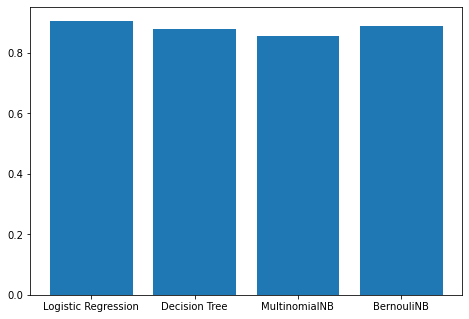

In [33]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
accuracies = [reports[0]['accuracy'], reports[2]['accuracy'], reports[4]['accuracy'], reports[5]['accuracy'] ]
models = ['Logistic Regression', 'Decision Tree', 'MultinomialNB', 'BernouliNB']
ax.bar(models,accuracies)
plt.show()

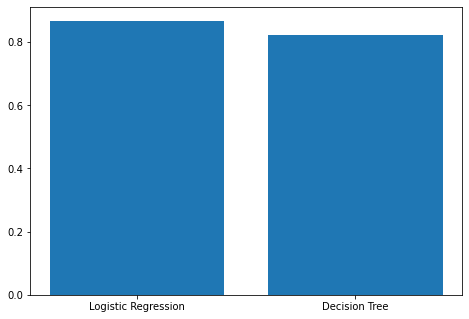

In [34]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
accuracies = [reports[1]['accuracy'], reports[3]['accuracy']]
models = ['Logistic Regression', 'Decision Tree']
ax.bar(models,accuracies)
plt.show()

# Testing the winner model

In [35]:
winner_grid = fit(('lr', LogisticRegression(random_state=0,max_iter=10000)), {'lr__C': [0.1,1.0,10.0]}, df_train_embedded_tfidf, df_train["emotions"], df_test_embedded_tfidf)

('lr', LogisticRegression(max_iter=10000, random_state=0))
{'lr__C': 10.0}
              precision    recall  f1-score   support

         joy       0.97      0.93      0.95       722
     sadness       0.90      0.91      0.90       574
       anger       0.82      0.87      0.84       260
        fear       0.85      0.87      0.86       219

    accuracy                           0.91      1775
   macro avg       0.88      0.90      0.89      1775
weighted avg       0.91      0.91      0.91      1775

[[673  10   5   7]
 [ 29 521  19  12]
 [ 12  28 226   9]
 [  8  15  10 191]]
None


/Users/adriallopgirones/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=['joy', 'sadness', 'anger', 'fear'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [40]:
test_sentence = "I'm afraid this place is not sure"
lemmatized_sentence = lemmatize_sentence(test_sentence)
vectors = vectorizer.transform([lemmatized_sentence])
dense = vectors.todense()
denselist = dense.tolist()
winner_grid.predict(vectors)

array(['fear'], dtype=object)

In [19]:
sentence = "Hello, I'm taking robotics class this semester"
print(preprocess(sentence))

hello im take robotics class semester


In [ ]:
That ice cream was delicious
I'm mad at you for what you did
What a terrible day I just wanna cry
I'm afraid this place is not sure

# Modeling - Deep Learning



In [71]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

In [188]:
Y_train = pd.get_dummies(df_train['emotions']).values

In [201]:
model = Sequential()
model.add(Embedding(5000, 100, input_length=df_train_embedded_tfidf.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64


history = model.fit(np.array(df_train_embedded_tfidf), Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/5
199/199 [==============================] - 506s 3s/step - loss: 1.2993 - accuracy: 0.3773 - val_loss: 1.3052 - val_accuracy: 0.3588
Epoch 2/5
199/199 [==============================] - 522s 3s/step - loss: 1.2949 - accuracy: 0.3761 - val_loss: 1.3025 - val_accuracy: 0.3588
Epoch 3/5
199/199 [==============================] - 606s 3s/step - loss: 1.2943 - accuracy: 0.3816 - val_loss: 1.3002 - val_accuracy: 0.3588
Epoch 4/5
199/199 [==============================] - 518s 3s/step - loss: 1.2940 - accuracy: 0.3820 - val_loss: 1.3012 - val_accuracy: 0.3588
Epoch 5/5
199/199 [==============================] - 604s 3s/step - loss: 1.2932 - accuracy: 0.3820 - val_loss: 1.3000 - val_accuracy: 0.3588


In [209]:
print(model.predict(np.array(df_test_embedded_tfidf)))
# print(accuracy_score(model.predict(np.array(df_test['tweets']), pd.get_dummies(df_test['emotions']))))

[[0.1543434  0.14247213 0.3728585  0.33032596]
 [0.1543434  0.14247213 0.3728585  0.33032596]
 [0.1543434  0.14247213 0.3728585  0.33032596]
 ...
 [0.15434338 0.14247212 0.37285846 0.33032596]
 [0.15434338 0.14247212 0.37285846 0.33032596]
 [0.15434338 0.14247212 0.37285846 0.33032596]]


In [49]:
def genrange(stop, start = 0, step = 1):
    """Generator version of range(stop)"""
    i = start
    while i < stop:
        yield i
        i = i + step

for i in genrange(5, 1):
    print(i)

1
2
3
4


In [48]:
print(range(5))

range(0, 5)
